# <h1><center>Content-based music recommender</center></h1>

## <center>Use a deep CNN and cosine similarity to recommend music</center>

## <center>Step 4: Build a deep CNN using TFLEARN library and evaluate the model</center>

## Import libraries, including librosa, tflearn

In [1]:
# install libraries if necessary
#import sys
#!{sys.executable} -m pip install tflearn
#!{sys.executable} -m pip install pyaudio #tensorflow
#!{sys.executable} -m pip install tensorflow
#!{sys.executable} -m pip install wave
#!{sys.executable} -m pip install librosa


In [2]:
import os
import re
import sys
import numpy as np
import pandas as pd

import pyaudio
import wave

import tensorflow as tf
import tflearn

from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import librosa
import librosa.display
import IPython.display

import matplotlib.pyplot as plt
import matplotlib.style as ms

ms.use('seaborn-muted')
%matplotlib inline

### Create functions to:   
1, Record music.  
2, Create the training set.  
3, Shuffle and prepare the training/testing set.  
4, Extract music features.  
5, Build the CNN model. 



Function 1: to record a piece of music for play and further prediction.  

The function to record audio to a wave file below was referred from Python pyaudio.Pyaudio() Examples. URL: https://www.programcreek.com/python/example/52624/pyaudio.PyAudio  

The same function was used in the application file **'musicrecommender.py'** too.

In [3]:
def recode(CHUNK=1024, FORMAT=pyaudio.paInt16, CHANNELS=2, RATE=44100,
           RECORD_SECONDS=30, WAVE_OUTPUT_FILENAME="record.wav"):
    '''
    :param CHUNK:  Frame per buffer size
    :param FORMAT: Format of sample
    :param CHANNELS: Channels number
    :param RATE: Sample rate
    :param RECORD_SECONDS: Record time
    :param WAVE_OUTPUT_FILENAME: output file name and path
    :return:
    '''
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)
    frames = []
    print "* recording"
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK, exception_on_overflow = False)
        frames.append(data)
    print "* done recording"
    stream.stop_stream()
    stream.close()
    p.terminate()
    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()


In [4]:
# test the record function
recode(RECORD_SECONDS=10, WAVE_OUTPUT_FILENAME='record.wav')

* recording
* done recording


Function 2: create dataset from music dataset pre-created feature files

In [2]:
def create_feature(train_df):
    rows_to_add_X = []
    rows_to_add_y = []
    for feature_file, target in zip(train_df['musicFeaturesFileName'], train_df['styleID']):
        file_to_load = features_files_dir + feature_file        
        feat = np.load(file_to_load)
        for i in range(len(feat)):
            rows_to_add_X.append(feat[i])
            rows_to_add_y.append(target)
    return np.array(rows_to_add_X), np.array(rows_to_add_y)



Function 3: shuffle the dataset and split dataset into training and testing dataset

In [3]:
def shuffle_data(X, y, num_of_classes = 8, test_size=0.2):
    from sklearn.utils import shuffle
    X_new, y_new = shuffle(X, y, random_state=0)

    #after that, split dataset, 20% to test set
    from sklearn.model_selection import train_test_split
    train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=1, test_size=test_size)

    # then re-generate y to one-hot vector
    from keras.utils import to_categorical
    train_y = to_categorical(train_y, num_classes=num_of_classes)
    test_y = to_categorical(test_y, num_classes=num_of_classes)
    
    return train_X, test_X, train_y, test_y

Function 4: to extract music features for prediction
It takes 20 seconds of music at 5 seconds, if the music is shorter; Or takes 20 seconds at user defined amount of time.

In [128]:
def extract_test_feature(fn, offset=5, duration=20):
    sound_clip, sr = librosa.load(fn, sr=11025, offset=offset, duration=duration)
    melspec = librosa.feature.melspectrogram(y=sound_clip, sr=sr, \
                            n_fft=1024, hop_length=512, n_mels=128)
    return melspec


Function 5: to build a CNN model  

The DNN model architecture was created based on Julien Despois, (2016). https://github.com/despoisj/DeepAudioClassification

The same model construction function was used in the application files **'musicrecommender.py', 'testdnn.py'** and **'traindnn.py'** too.

In [5]:
# Define the optimization methods.
sgd = tflearn.optimizers.SGD(learning_rate=0.01, lr_decay=0.96, decay_step=100)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
rmsprop = tflearn.optimizers.RMSProp(learning_rate=0.001, decay=0.999)
adam = tflearn.optimizers.Adam(learning_rate=0.001, beta1=0.99)

def createModel(nbClasses=8, imageSize1=128, imageSize2=431):
    
    print("[.] Creating DNN model")
    
    convnet = input_data(shape=[None, imageSize1, imageSize2, 1], name='input')

    convnet = conv_2d(convnet, 64, 2, activation='relu', weights_init="Xavier")
    convnet = max_pool_2d(convnet, 2)

    convnet = conv_2d(convnet, 128, 2, activation='relu', weights_init="Xavier")
    convnet = max_pool_2d(convnet, 2)

    convnet = conv_2d(convnet, 256, 2, activation='relu', weights_init="Xavier")
    convnet = max_pool_2d(convnet, 2)

    convnet = conv_2d(convnet, 512, 2, activation='relu', weights_init="Xavier")
    convnet = max_pool_2d(convnet, 2)

    convnet = fully_connected(convnet, 1024, activation='relu')
    convnet = dropout(convnet, 0.5)

    convnet = fully_connected(convnet, nbClasses, activation='softmax')
    convnet = regression(convnet, optimizer=adam, loss='categorical_crossentropy')
    
    music_model = tflearn.DNN(convnet)
    
    print("    Model created.")

    return music_model



## Load a music, play it, display waveform and Mel spectrogram

In [9]:
# Load a wav file
y, sr = librosa.load('record.wav', sr=None)
print "Sample rates=",sr,"Hz"

Sample rates= 44100 Hz


In [10]:
# Play
IPython.display.Audio(data=y, rate=sr, autoplay=False)

Mel spectrogram feature: (128, 861)


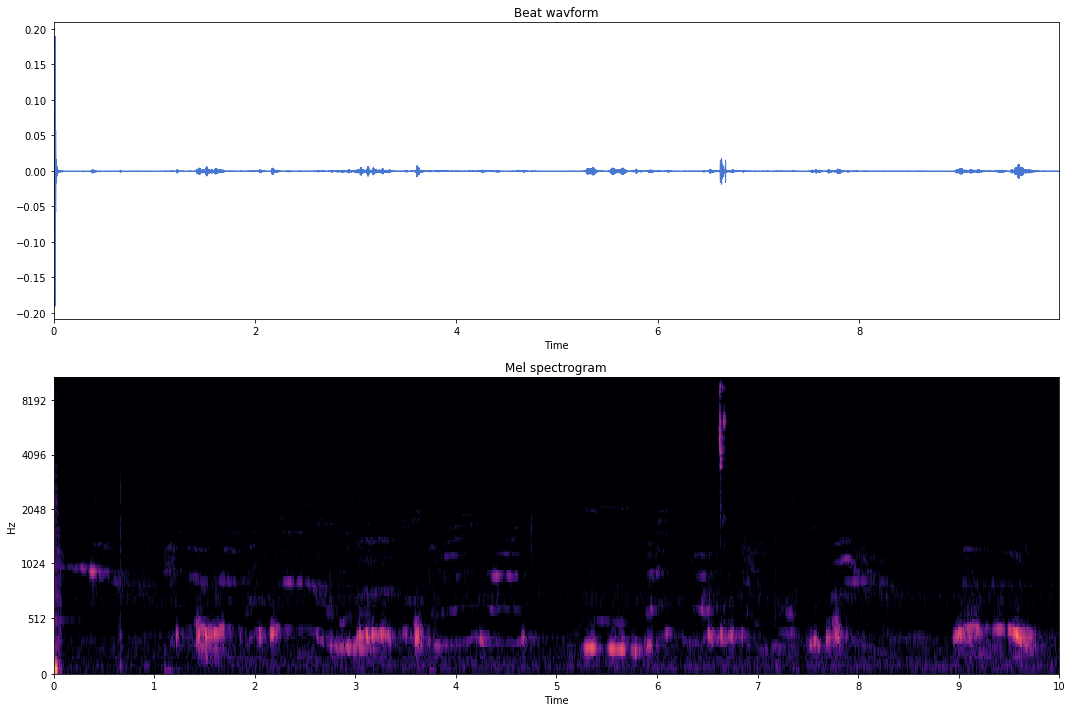

In [11]:
# extract mel spectrogram feature
melspec = librosa.feature.melspectrogram(y, sr, n_fft=1024, hop_length=512, n_mels=128)
# convert to log scale
logmelspec = librosa.power_to_db(melspec)
print "Mel spectrogram feature:", logmelspec.shape

plt.figure(figsize=(15, 10))
# plot a beat wavform
plt.subplot(2, 1, 1)
librosa.display.waveplot(y = y, sr = sr)
plt.title('Beat wavform')
# plot mel spectrogram
plt.subplot(2, 1, 2)
librosa.display.specshow(logmelspec, sr = sr, x_axis = 'time', y_axis = 'mel')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()


## Prepare training and testing dataset

In [4]:
#the path where the extracted music feature files will be saved
features_files_dir = './music/MusicFeatures/'
#the path of the file of music's other infomation
music_info_dir = './music/MusicInfo/'
# read in data using pandas
train_df = pd.read_csv (music_info_dir + "Step3_integrated_music_info.csv")
#target values
train_df['styleID'].unique()

array([6, 1, 7, 5, 4, 3, 2, 0])

In [7]:
# music style mapping
style_Mapping = ["rock", "metal", "pop", "punk", "folk", "hop", "black", "country"]

# class count
NUM_CLASSES = len(train_df['styleID'].unique())
NUM_CLASSES


8

## Training a Deep CNN model, evaluation and test

Tflearn preprocessing: create dataset X, y using the function created above

In [8]:
X, y = create_feature(train_df)

split dataset into training and testing set

In [9]:
train_X, test_X, train_y, test_y = shuffle_data(X, y, NUM_CLASSES)

Using TensorFlow backend.


Tflearn step 1: reshape data

In [11]:
input_size1 = train_X.shape[1]
input_size2 = train_X.shape[2]

train_X = train_X.reshape(-1, input_size1, input_size2, 1)
test_X = test_X.reshape(-1, input_size1, input_size2, 1)


Tflearn step 2: create Deep CNN model.

In [12]:
model = createModel(NUM_CLASSES, input_size1, input_size2)

[.] Creating DNN model
Instructions for updating:
keep_dims is deprecated, use keepdims instead
    Model created.


Tflearn step 3: start to training

In [16]:
print("[.] Model is training")
model.fit(train_X, train_y, n_epoch=1, batch_size=32, shuffle=True, \
          validation_set=0.2, snapshot_step=5, show_metric=True)

print("    Model trained.")


Training Step: 1207  | total loss: 1.34482 | time: 14467.198s
| Adam | epoch: 001 | loss: 1.34482 - acc: 0.5057 -- iter: 9632/9654
Training Step: 1208  | total loss: 1.33848 | time: 14593.645s
| Adam | epoch: 001 | loss: 1.33848 - acc: 0.5145 | val_loss: 1.40357 - val_acc: 0.4714 -- iter: 9654/9654
--
    Model trained.


### Due to the huge amount of calculation needed, and we don't have a GPU to help with the training, we have stopped training at iteration = 4, with an accuracy of 42.5% on the testing set, 47.2% on the validation set and 51.2% on the training set.

Tflearn step 4: evaluate the trained model with testing set

In [22]:
accuracy=model.evaluate(test_X,test_y)
print("Accuracy:", accuracy)

('Accuracy:', [0.42459396726056997])


Now we predict the testing set and create a confusion matrix. We did not use tflearn predict() function here as it caused dead kernel for some reason.

In [53]:
#prediction = model.predict(test_X) # it caused kernel restart, dont use it, But why?
prediction = []
for i in range(len(test_X)):
    res = model.predict([test_X[i]])
    prediction.append(np.array(res))


In [124]:
# print tf.confusion_matrix(test_y, pred, num_classes=NUM_CLASSES)
# it's not working as prediction was created manually
# user define function to calculate confusion_matrix

def pred_style_pred(result):
    r_max = -1
    voted_max = 0
    for j in range(8):
        if result[0][j] > r_max:
            r_max = result[0][j]
            voted_max = j
    return voted_max

def pred_style_test(result):
    r_max = -1
    voted_max = 0
    for j in range(8):
        if result[j] > r_max:
            r_max = result[j]
            voted_max = j
    return voted_max

confusion_matrix = np.zeros((8,8),dtype=int)
confusion_matrix_comp = np.zeros((8,8),dtype=int)
for i, j in zip(prediction, test_y):
    x_test = pred_style_test(j)
    x_pred = pred_style_pred(i)
    confusion_matrix[x_test][x_pred] += 1
    confusion_matrix_comp[x_test][x_test] += 1

print "Confusion matrix:"
print confusion_matrix
print "\nWhat's in the testing set:"
print confusion_matrix_comp

    

Confusion matrix:
[[ 68  71  17 112  82  29  16   8]
 [ 31 239   6  71  41  16  40   3]
 [ 33  17  84  38 102 121  10  16]
 [ 40  55  20 151  45  14   8   3]
 [ 19  34  23  34 248  44  16  27]
 [ 13   7  25  12  80 267   6   3]
 [ 12  56   5  10  21  39 178   2]
 [ 20  11  17  23  88  24   0  46]]

What's in the testing set:
[[403   0   0   0   0   0   0   0]
 [  0 447   0   0   0   0   0   0]
 [  0   0 421   0   0   0   0   0]
 [  0   0   0 336   0   0   0   0]
 [  0   0   0   0 445   0   0   0]
 [  0   0   0   0   0 413   0   0]
 [  0   0   0   0   0   0 323   0]
 [  0   0   0   0   0   0   0 229]]


According to the confusion matrix, we can conclude the overall accuracy on different music genres:

Rock: 17%

Metal: 54%

Pop: 20%

Punk: 45%

Folk: 56%

Hop: 65%

Black: 55%

Country: 20%



Tflearn step 5: save trained model to file.

In [125]:
print("[.] Save the weights")
model.save('content_music_recommender.tfl')
print("    Weights saved.")


[.] Save the weights
INFO:tensorflow:/Users/jerrywang/Documents/158755/project4/content_music_recommender.tfl is not in all_model_checkpoint_paths. Manually adding it.
    Weights saved.


The code below is a demo of how to load a saved model for further prediction.

In [126]:
#model = createModel(NUM_CLASSES, input_size1, input_size2)
print("[.] Load the weights")
model.load('content_music_recommender.tfl')
print("    Weights loaded.")

[.] Load the weights
INFO:tensorflow:Restoring parameters from /Users/jerrywang/Documents/158755/project4/content_music_recommender.tfl
    Weights loaded.


Tflearn step 6: some prediction results from given music.

In [129]:
def pred_style(result):
    r_max = -1
    voted_max = 0
    for j in range(len(result[0])):
        if result[0][j] > r_max:
            r_max = result[0][j]
            voted_max = j
    return voted_max

# test
def test_model(fn, offset=5):
    test_feature = extract_test_feature(fn, offset=offset)
    test_feature_feed = test_feature.reshape(-1, input_size1, input_size2, 1)
    result = model.predict(test_feature_feed)
    print result
    print ("Predict result = %d  styleID = %s " % (pred_style(result), style_Mapping[pred_style(result)]))

In [144]:
test_model("./5 Hop Lil wayne-drop the world lyrics-dirty version.mp3")

[[3.9406894e-03 4.8287190e-03 1.2574485e-02 2.1093222e-03 6.4029465e-03
  9.5930511e-01 1.0827171e-02 1.1605239e-05]]
Predict result = 5  styleID = hop 


This music was correctly predicted.

In [143]:
test_model("./4 Folk Ed Sheeran - Shape of You.mp3")

[[0.12442607 0.05907007 0.09534576 0.06693528 0.29726398 0.11732904
  0.02821332 0.21141641]]
Predict result = 4  styleID = folk 


This music was correctly predicted as well.

In [142]:
test_model("./2 Pop Maroon 5 - Sugar (lyrics).mp3")

[[0.13939413 0.04219169 0.17923838 0.12687564 0.1635227  0.19182338
  0.03564483 0.12130923]]
Predict result = 5  styleID = hop 


This music was incorrectly predicted.

**From the test result above, we can indicate that some of the music has been correctly labeled, however, the last one was predicted wrong. The main reason is that we have mixed some multi-labeled music as one single label music in the training set.**

## Reference:  

1, Julien Despois, (2016). https://github.com/despoisj/DeepAudioClassification  
2, Python pyaudio.Pyaudio() examples. https://www.programcreek.com/python/example/52624/pyaudio.PyAudio